## **70028 - Reinforcement Learning: Coursework 2**
### Belfiore Asia, cid: 02129867
---

In [43]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss, epsilon_greedy_decay

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import random # added import
import numpy as np
import pandas as pd # added import

import gym
import matplotlib.pyplot as plt

In [44]:
NUM_RUNS = 10 # [OK]

# 1 - tuning hyperparameters 
# 2 - introduce basic exploration-exploitation handling

A = 6 # size of each hidden layer
B = 2 # number of DQN hidden layers
C = 0.01 # learning rate
D = 10000 # size of Replay Buffer
E = 300 # [OK] number of training episodes (needs to stabilise for >50)
F = 0.2 # epsilon value for epsilon-greedy policy
# DECAY_RATE = 0.995 # epsilon decay rate
G = 1 # reward discount factor
H = 50 # size of replay sampled training batch
I = 75 # frequency (number of steps) of target network update


def print_hyperparameters():
    print("\nHyperparameters:")
    print(f"A = {A} # size of each hidden layer")
    print(f"B = {B} # number of DQN hidden layers,")
    print(f"C = {C} # learning rate")
    print(f"D = {D} # size of Replay Buffer")
    print(f"E = {E} # number of training episodes")
    print(f"F = {F} # epsilon value for epsilon-greedy policy")
    # print(f"DECAY_RATE = {DECAY_RATE} # epsilon decay rate")
    print(f"G = {G} # reward discount factor")
    print(f"H = {H} # size of replay sampled training batch")
    print(f"I = {I} # frequency (number of steps) of target network update")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Starting run 5 of 10
Starting run 10 of 10
Complete
Model saved.

Hyperparameters:
A = 6 # size of each hidden layer
B = 2 # number of DQN hidden layers,
C = 0.01 # learning rate
D = 10000 # size of Replay Buffer
E = 300 # number of training episodes
F = 0.2 # epsilon value for epsilon-greedy policy
G = 1 # reward discount factor
H = 50 # size of replay sampled training batch
I = 75 # frequency (number of steps) of target network update


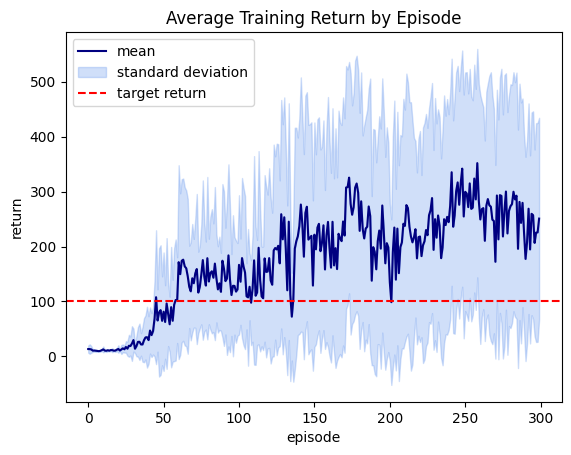

In [46]:
runs_results = []

env = gym.make('CartPole-v1')
for run in range(NUM_RUNS):
    if (run+1) % 5 == 0: print(f"Starting run {run+1} of {NUM_RUNS}")
    layers = [4] + [A]*B + [2]
    policy_net = DQN(layers)
    target_net = DQN(layers)
    update_target(target_net, policy_net)
    target_net.eval()

    # optimizer = optim.SGD(policy_net.parameters(), lr=C)
    optimizer = optim.Adam(policy_net.parameters(), lr=C)
    memory = ReplayBuffer(D)

    steps_done = 0

    episode_durations = []

    for i_episode in range(E):
        # if (i_episode+1) % 50 == 0:
        #     print("episode ", i_episode+1, "/", 300)

        observation, info = env.reset()
        state = torch.tensor(observation).float()

        done = False
        terminated = False
        t = 0
        while not (done or terminated):

            # Select and perform an action
            action = epsilon_greedy(F, policy_net, state)
            # action = epsilon_greedy_decay(F, DECAY_RATE, i_episode, policy_net, state)

            observation, reward, done, terminated, info = env.step(action)
            reward = torch.tensor([reward])/G
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()

            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < H:
                transitions = memory.sample(H)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                # Optimize the model
                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()
            
            if done or terminated:
                episode_durations.append(t + 1)
            t += 1
            steps_done += 1
            # Update the target network, copying all weights and biases in DQN
            if steps_done % I == 0: 
                update_target(target_net, policy_net)
    runs_results.append(episode_durations)
print('Complete')


torch.save(policy_net, "model/policy_net.pth")
torch.save(target_net, "model/target_net.pth")
print("Model saved.")


############################################################################################################

# Plotting the learning curve
print_hyperparameters()

num_episodes = len(runs_results[0])
results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)

plt.plot(torch.arange(num_episodes), means, color='navy', label='mean')
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(num_episodes), means, means+stds, alpha=0.3, color='cornflowerblue', label='standard deviation')
plt.fill_between(np.arange(num_episodes), means, means-stds, alpha=0.3, color='cornflowerblue')
plt.axhline(y = 100, color = 'r', linestyle = '--',label= "target return")
plt.legend(loc='upper left')
plt.title("Average Training Return by Episode")
plt.show()

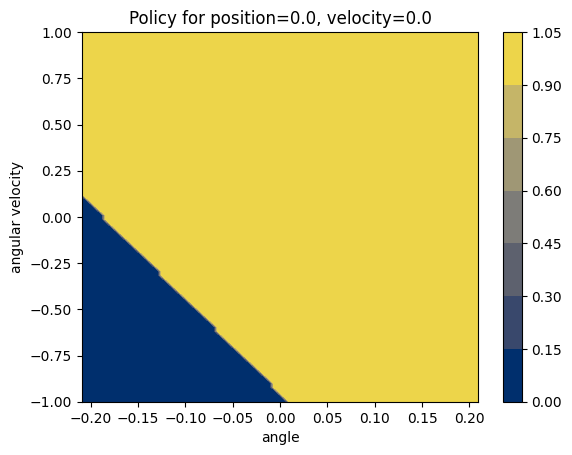

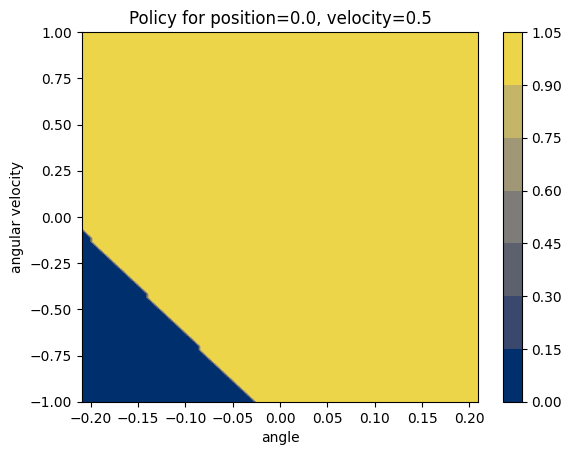

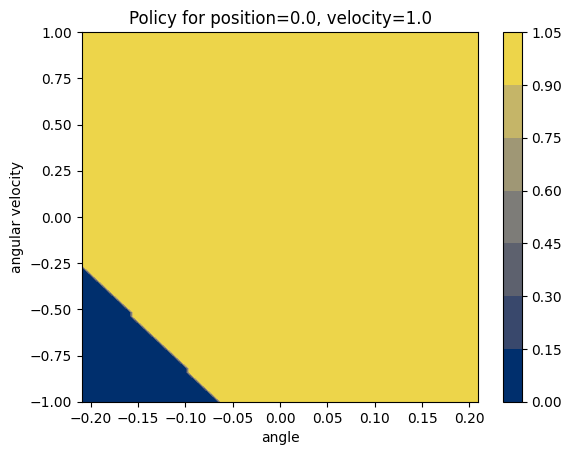

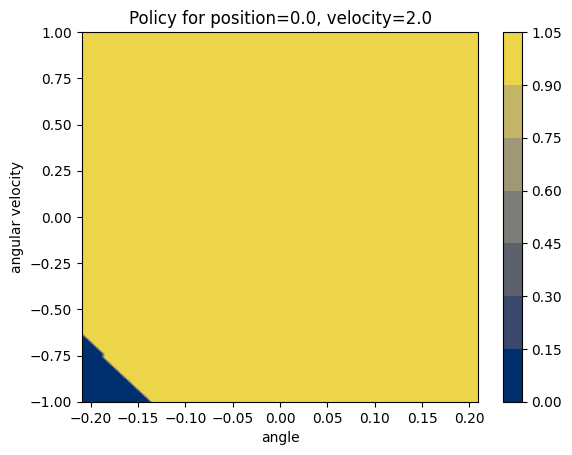

In [47]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can freely modify these plots and code

# Make sure to include appropriate labels and/or legends when presenting your plot

# ---


# net = torch.load("model/target_net.pth", weights_only=False)
# net.eval()

net = torch.load("model/policy_net.pth", weights_only=False)
net.eval()
q = False    # whether q values or greedy policy is visualised

# DELETE THIS
# rand_net = DQN(layers)
# q_vals = rand_net(state)

# Fix the cart position to the centre of the track (0) 
# and use cart velocities of 0., 0.5, 1. and 2.
position = 0.
velocities = [0., 0.5, 1., 2.]
# velocity = velocities[0] 

for velocity in velocities:
# for q in [True, False]: # whether q values or greedy policy is visualised
    angle_range = .2095 # you may modify this range
    omega_range = 1     # you may modify this range

    angle_samples = 100
    omega_samples = 100
    angles = torch.linspace(angle_range, -angle_range, angle_samples)
    omegas = torch.linspace(-omega_range, omega_range, omega_samples)

    greedy_q_array = torch.zeros((angle_samples, omega_samples))
    policy_array = torch.zeros((angle_samples, omega_samples))
    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            state = torch.tensor([position, velocity, angle, omega]) # center position
            with torch.no_grad():
                q_vals = policy_net(state)
                greedy_action = q_vals.argmax()
                greedy_q_array[i, j] = q_vals[greedy_action]
                policy_array[i, j] = greedy_action
    if q:
        plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
        plt.title(f"Q Value for position={position}, velocity={velocity}")
    else:
        plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
        plt.title(f"Policy for position={position}, velocity={velocity}")
    plt.colorbar()
    plt.xlabel("angle")
    plt.ylabel("angular velocity")
    plt.show()